# 实验四 基于混合高斯模型的二分类
PB19071509 王瑞哲

## >>> 实验目标

基于实验3利用单个多元高斯模型解决二分类问题，这里利用混合多个高斯模型来解决二分类问题。假设两类有相同的先验概率。每个观测样本的特征是3维向量。用 k-means 来初始化 GMM，然后基于 EM 算法来迭代提升 GMM 模型预测准确率。尝试分别使用 2，4，8 mixture 的 GMM 来建模此分类问题

## >>> 实验原理

高斯混合模型（GMM）可以看作是由 K 个单高斯模型组合而成的模型。混合高斯模型：
$$\ln p(\vec{X}|\vec{\mu},\vec{\Sigma},\vec{\pi})=\sum_{n=1}^N\ln\bigg\{\sum_{k=1}^K\pi_k\mathcal{N}(\vec{x}|\vec{\mu_k},\vec{\Sigma_k})\bigg\}$$
$$\mathcal{N}(\vec{x}|\vec{\mu_k},\vec{\Sigma_k})=\frac{1}{(2\pi)^{D/2}}\frac{1}{|\Sigma_k|^{1/2}}\exp\bigg(-\frac{1}{2}(\vec{x}-\vec{\mu_k})^T\vec{\Sigma_k}^{-1}(\vec{x}-\vec{\mu_k})\bigg)$$
其中各参数的计算方法：
$$\vec{\mu}_k = \frac{1}{N_k}\sum_{n=1}^N\gamma_{nk}\vec{x}_n, where: N_k=\sum_{n=1}^N\gamma_{nk}$$
$$\Sigma_k=\frac{1}{N_k}\sum_{n=1}^N\gamma_{nk}(\vec{x}_n-\vec{\mu}_k)(\vec{x}_n-\vec{\mu}_k)^T$$
$$\hat\pi_k=\frac{N_k}{N}$$

K-Means算法是一种聚类分析（cluster analysis）的算法，其主要是来计算数据聚集的算法，主要通过不断地取离种子点最近均值的算法。它适用于无监督的学习，事先不知道类别，自动将相似的对象归到同一个簇中。


## >>> 实验过程

导入必要的包；定义导入训练、测试数据的函数

In [138]:
import numpy as np
import re

def dataloader(filename):
    f = open(filename, "r")
    A_Set = []
    B_Set = []
    for line in f.readlines():
        cls = 1 if line[0]=='A' else 0
        data = re.search(r"(?<=\().*(?=\))", line).group()  # Using regular expressions match data
        if cls:
            A_Set.append(data.split(' '))
        else:
            B_Set.append(data.split(' '))
    # assert input matrix: [num_samples*dimension] every row represents a sample
    A_Set = np.array(A_Set).astype(float)     # 1.Change list to np.array; 2.Change data type for future calculation
    B_Set = np.array(B_Set).astype(float)
    return A_Set, B_Set

定义具有k个多元高斯模型的混合高斯模型类

In [139]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
# from tqdm import tqdm

class Mul_Gaussian_model():
    def __init__(self, num_of_models, dimension) -> None:
        self.num_of_models = num_of_models
        self.dimension = dimension
        self.mu = np.zeros([num_of_models, dimension])
        self.sigma = np.ones([num_of_models, dimension, dimension])
        self.mix_coeffi = np.ones([num_of_models]) / num_of_models

    def initModel(self, trainData):
        # assert input matrix: [num_samples*dimension] every row represents a sample
        kmeans = KMeans(n_clusters=self.num_of_models).fit(trainData)
        # calculate each set of parameters of each Gaussian Model
        for i in range(self.num_of_models):
            data = trainData[kmeans.labels_==i]
            self.mu[i] = np.mean(data, axis=0)                              # calculate mean (followed by row)
            self.sigma[i] = np.cov(data.T)                                  # calculate varience (need transpose to get [dimension*dimension] result)
            self.mix_coeffi[i] = np.sum(kmeans.labels_==i) / len(trainData)    # update the mixing coefficents

        return self

    def trainModel(self, trainData, num_of_iter=100):

        # train model based on EM algorithm
        for _ in range(num_of_iter):
            
            # calculate density
            density = np.empty((len(trainData), self.num_of_models))
            for i in range(self.num_of_models):
                norm = multivariate_normal(self.mu[i], self.sigma[i])
                density[:,i] = norm.pdf(trainData)
            # calculate N_k based on the formular
            posterior = density * self.mix_coeffi
            posterior = posterior / posterior.sum(axis=1, keepdims=True)
            N_k = posterior.sum(axis=0)
            # caculate mu, sigma
            mu_hat = np.tensordot(posterior, trainData, axes=[0, 0])
            sigma_hat = np.empty(self.sigma.shape)
            for i in range(self.num_of_models):
                tmp = trainData - self.mu[i]
                sigma_hat[i] = np.dot(tmp.T*posterior[:,i], tmp) / N_k[i]
            # update all the parameters
            self.sigma = sigma_hat
            self.mu = mu_hat / N_k.reshape(-1,1)
            self.mix_coeffi = N_k / len(trainData)

        return self

    def forward(self, input):
        p = np.zeros([self.num_of_models])
        for i in range(self.num_of_models):
            norm = multivariate_normal(self.mu[i], self.sigma[i])
            p[i] = norm.pdf(input)
        return p.mean()

定义评估函数，来判断训练得到的结果在测试集上的准确率

In [140]:
def evaluation(modelA, modelB, filename):
    Test_A, Test_B = dataloader(filename)
    acc_num = 0
    for i in Test_A:
        if modelA.forward(i) >= modelB.forward(i):
            acc_num += 1
    for i in Test_B:
        if modelB.forward(i) >= modelA.forward(i):
            acc_num += 1
    acc = acc_num / (Test_A.shape[0] + Test_B.shape[0])
    return acc

正式开始训练与推断

In [141]:
def train_and_infer(num_of_models, num_of_iter):
    #  train
    Train_set_A, Train_set_B = dataloader("Train.txt")
    G_A = Mul_Gaussian_model(num_of_models, dimension=3)
    G_B = Mul_Gaussian_model(num_of_models, dimension=3)
    G_A = G_A.initModel(Train_set_A)
    G_A = G_A.trainModel(Train_set_A, num_of_iter)
    G_B = G_B.initModel(Train_set_B)
    G_B = G_B.trainModel(Train_set_B, num_of_iter)
    
    # infer
    acc = evaluation(G_A, G_B, "Test.txt")
    return acc

acc = train_and_infer(num_of_models=2, num_of_iter=100)
print("The acc of this Gaussian Model is {:.3f}%".format(100*acc))

The acc of this Gaussian Model is 76.506%


比较模型个数为2，4，8时的预测准确率，并对比不同迭代次数的预测结果

In [142]:
num_list = [2, 4, 8]
iter_list = [0, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400]
acc_all = np.zeros([len(num_list), len(iter_list)])
for i,num in enumerate(num_list):
    for j,iter in enumerate(iter_list):
        acc = train_and_infer(num_of_models=num, num_of_iter=iter)
        acc_all[i][j] = acc

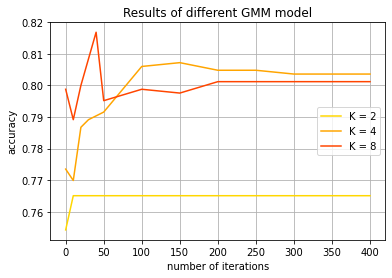

In [143]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(iter_list, acc_all[0], color='gold', label='K = 2')
plt.plot(iter_list, acc_all[1], color='orange', label='K = 4')
plt.plot(iter_list, acc_all[2], color='orangered', label='K = 8')
plt.title("Results of different GMM model")
plt.xlabel("number of iterations")
plt.ylabel("accuracy")
plt.grid()
plt.legend()
plt.show()

## >>> 实验总结

通过本次实验，我了解了混合多元高斯模型的基本理论基础，了解了KMeans算法和EM算法，学会了利用代码编写训练混合多元高斯模型的过程，并将其应用于模型评测中

除此之外，本次代码中继承了实验三所定义的各种的类、函数，同时在类内定义了更多丰富的功能，并在推理阶段定义了绘图函数以更清晰地展示训练结果

在实验三中，单个高斯模型的准确率结果约为75.7%。在本次实验中，2个模型混合后准确率预测结果约为76.5%，虽然比单个模型准确率高，但其准确率在迭代过程增加的过程中并没有进一步增加，所以说明二模型混合的拟合能力仍有提高空间。4模型混合后准确率预测结果随迭代过程增加有明显增长，且最后能稳定在80.5%左右，表现较好。8模型混合后准确率预测结果随迭代过程增加有较大波动，且数值结果不如4模型，说明应是出现了过拟合现象。

综上，混合多元高斯模型的拟合能力整体上比单个多元高斯模型好很多，但同时也需根据训练集规模和具体问题情况来选择模型的复杂度，以此获得更好的模型拟合能力。